In [71]:
import geopandas as gpd
import pandas as pd
import contextily as ctx
import pathlib
import numpy as np
import networkx
from matplotlib import pyplot as plt
from shapely.geometry import Point, Polygon, LineString
import ee
import geemap

In [ ]:
#ee.Authenticate()

In [ ]:
#ee.Initialize()

# Storm Forecasts & Track
Storm forecasts and historical track will be published for each in-game day.

The forecasts represent model predictions for where the hurricane might be at the given timestamp.

The storm track represents the true path that the storm took in the past.

In [72]:
# Forecasts
link = 'https://files.bwsi-remote-sensing.net/data/final_2024/day1/day1_forecasts_2024.geojson'
daily_forecast = gpd.read_file(link)


In [39]:
daily_forecast[daily_forecast['prediction'] == 2]

,prediction,forecastHour,datetime,maxWinds,category,geometry,buffer_amount
8,2,12,2023-08-02 08:00:00,70,1,"POLYGON ((-69.54522 37.96624, -69.54505 37.960...",160
9,2,24,2023-08-02 20:00:00,75,1,"POLYGON ((-70.28864 38.90108, -70.28855 38.898...",80
10,2,36,2023-08-03 08:00:00,85,2,"POLYGON ((-71.25479 39.57007, -71.25471 39.567...",80
11,2,48,2023-08-03 20:00:00,85,2,"POLYGON ((-71.20611 39.9027, -71.20602 39.9, -...",80
12,2,60,2023-08-04 08:00:00,100,3,"POLYGON ((-70.99188 41.06799, -70.99179 41.065...",80
13,2,72,2023-08-04 20:00:00,105,3,"POLYGON ((-72.31288 42.14545, -72.31279 42.142...",80
14,2,96,2023-08-05 20:00:00,90,2,"POLYGON ((-71.03892 43.35662, -71.03884 43.354...",80
15,2,120,2023-08-06 20:00:00,65,1,"POLYGON ((-69.51872 42.93939, -69.51855 42.934...",160


In [73]:
random_color = lambda: np.random.random(3)

In [16]:
# look at the forecasts

#day1_grouped = daily_forecast.copy()
daily_forecast['maxWinds'].head(30)

0      70
1      75
2      85
3      85
4     100
5     105
6      90
7      65
8      70
9      75
10     85
11     85
12    100
13    105
14     90
15     65
16     70
17     75
18     85
19     85
20    100
21    105
22     90
23     65
24     70
25     75
26     85
27     85
28    100
29    105
Name: maxWinds, dtype: int32

In [17]:
#day1_forecast[day1_forecast['category'] == 3]

In [18]:
# # each forecast report has a number of possible hurricane routes
# # they are identified by the prediction column

# #fig, ax = plt.subplots(1, 1, figsize=(10,10))
# daily_forecast = daily_forecast.to_crs(epsg=3857) 
# daily_forecast['geometry'] = daily_forecast.geometry.buffer(daily_forecast['maxWinds'] * 1000) #Run Only ONCE
# daily_forecast = daily_forecast.to_crs(epsg=4326) 


# ax = day1_forecast.plot(edgecolor='k', label='Buffered Areas')
# ctx.add_basemap(ax, crs=day1_forecast.crs, source = ctx.providers.CartoDB.Voyager)
# #plt.show()
# #fig, ax = plt.subplots(1, 1, figsize=(10,10))
# # for pred_id, pred in day1_forecast.groupby('prediction'):
# #     print(pred)
# #     #c = random_color()
# #     #pred.plot(color=c, ax=ax)
# #     #line_to_plot = LineString(pred.geometry.values)
# #     #ax.plot(line_to_plot.xy[0], line_to_plot.xy[1], color=c, label=f'{pred_id}')
# # ax.legend(title='prediction id')
# #day1_forecast.plot(ax=ax, color='red', alpha=0.5, edgecolor='k', label='Buffered Areas')


In [34]:
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))

# category1 = day2_forecast[day2_forecast['maxWinds'] >= 39]
# category2 = day2_forecast[day2_forecast['maxWinds'] >= 58]
# category3 = day2_forecast[day2_forecast['maxWinds'] >= 74]

# categories = [category1, category2, category3]
# axes = [ax1, ax2, ax3]
# buffers = [300, 160, 80]

# for i in range(3):
#     categories[i] = categories[i].to_crs(epsg=3857) 
#     categories[i]['geometry'] = categories[i].geometry.buffer(buffers[i] * 1000) #Run Only ONCE
#     categories[i] = categories[i].to_crs(epsg=4326) 

#     categories[i].plot(ax = axes[i], label='Buffered Areas')
#     ctx.add_basemap(axes[i], crs=categories[i].crs, source = ctx.providers.CartoDB.Voyager)

daily_forecast['prediction'].head(36)

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     2
9     2
10    2
11    2
12    2
13    2
14    2
15    2
16    3
17    3
18    3
19    3
20    3
21    3
22    3
23    3
24    4
25    4
26    4
27    4
28    4
29    4
30    4
31    4
32    5
33    5
34    5
35    5
Name: prediction, dtype: int32

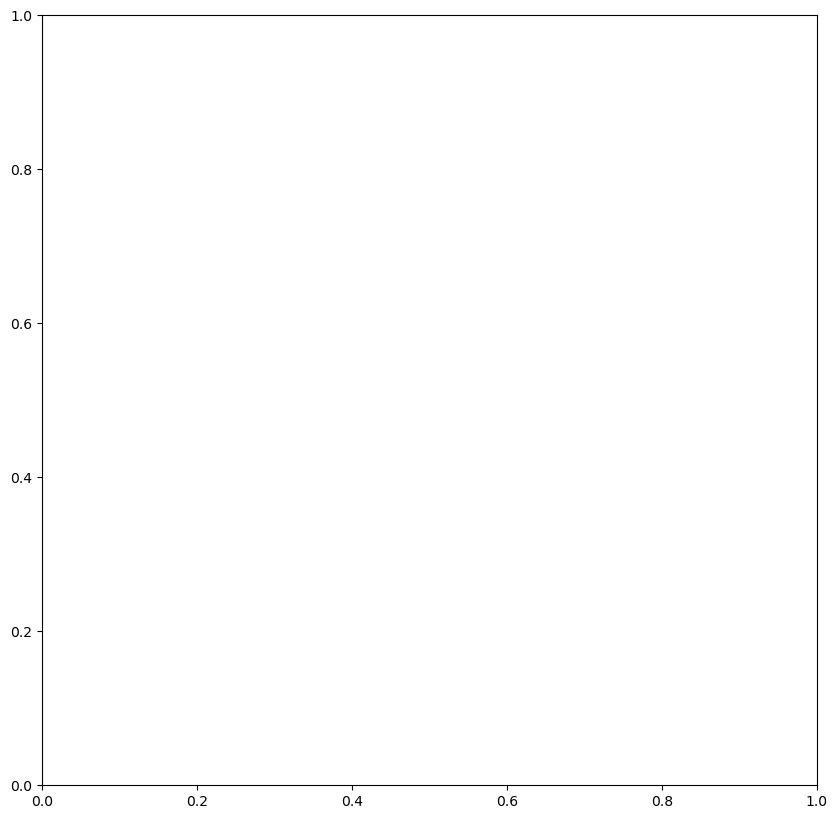

In [74]:
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# category1 = day1_forecast[day1_forecast['maxWinds'] >= 39]
# category2 = day1_forecast[day1_forecast['maxWinds'] >= 58]
# category3 = day1_forecast[day1_forecast['maxWinds'] >= 74]

def visualizeUncertainty(all_forecasts):
    forecasts_list = all_forecasts.geometry

    merged = forecasts_list[0].union(forecasts_list[1]).convex_hull

    for i in range(1, len(forecasts_list)-1): #iterates over polygons
        next = forecasts_list[i].union(forecasts_list[i+1]).convex_hull
        merged = merged.union(next)


    return merged

# def buff(x):
#     if x >= 74:
#         return 80
#     elif x >= 58:
#         return 160
#     elif x >= 39:
#         return 300
daily_forecast = daily_forecast[daily_forecast.geometry.notnull() & daily_forecast.geometry.is_valid]
daily_forecast = daily_forecast.reset_index(drop=True)
#daily_forecast['buffer_amount'] = daily_forecast['maxWinds'].apply(buff)
#daily_forecast = daily_forecast.to_crs(epsg=3857) 
#daily_forecast['geometry'] = daily_forecast['geometry'].buffer(daily_forecast['buffer_amount'] * 1000)
#daily_forecast = daily_forecast.to_crs(epsg=4326) 
#daily_forecast.plot()
# for pred_id, pred in daily_forecast.groupby('prediction'):
#     print(pred)
    #c = random_color()
    #pred.plot(color=c, ax=ax)
    #line_to_plot = LineString(pred.geometry.values)
    #ax.plot(line_to_plot.xy[0], line_to_plot.xy[1], color=c, label=f'{pred_id}')
#ax.legend(title='prediction id')
#daily_forecast.plot(ax=ax, color='red', alpha=0.5, edgecolor='k', label='Buffered Areas')
#ctx.add_basemap(ax, crs=category3.crs, source = ctx.providers.CartoDB.Voyager)

    
    # category1 = category1.to_crs(epsg=3857) 
# category1['geometry'] = category1.geometry.buffer(300 * 1000) #Run Only ONCE
# category1 = category1.to_crs(epsg=4326) 

# category1.plot(ax = ax1, label='Buffered Areas')
# ctx.add_basemap(ax1, crs=category1.crs, source = ctx.providers.CartoDB.Voyager)


# category2 = category2.to_crs(epsg=3857) 
# category2['geometry'] = category2.geometry.buffer(160 * 1000) #Run Only ONCE
# category2 = category2.to_crs(epsg=4326) 

# category2.plot(ax = ax2, label='Buffered Areas')
# ctx.add_basemap(ax2, crs=category2.crs, source = ctx.providers.CartoDB.Voyager)


# category3 = category3.to_crs(epsg=3857) 
# category3['geometry'] = category3.geometry.buffer(80 * 1000) #Run Only ONCE
# category3 = category3.to_crs(epsg=4326) 

# category3.plot(ax = ax3, label='Buffered Areas')
# ctx.add_basemap(ax3, crs=category3.crs, source = ctx.providers.CartoDB.Voyager)

<Axes: >

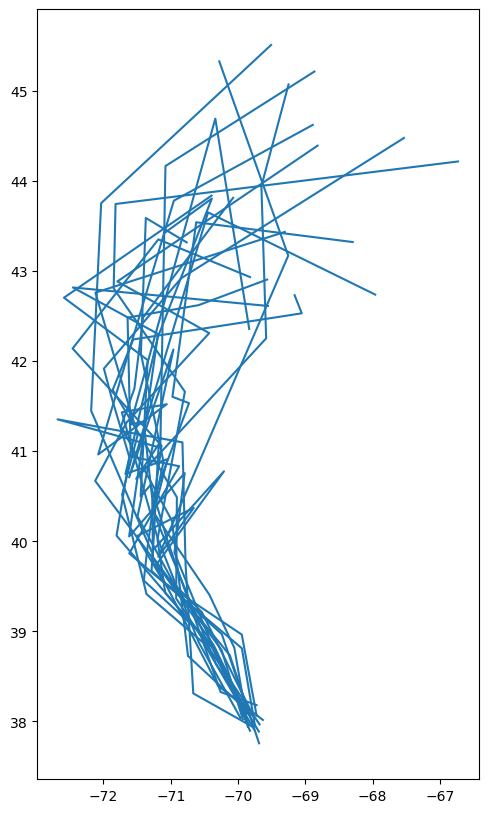

In [76]:
def visualizeUncertainty(all_forecasts):
    forecasts_list = all_forecasts.geometry.reset_index(drop=True)
    if len(forecasts_list) == 0:
        return None  # Return None if forecasts_list is empty

    # Start with the first polygon
    merged = forecasts_list.iloc[0]
    
    # Merge remaining polygons
    for geom in forecasts_list.iloc[1:]:
        merged = merged.union(geom).convex_hull
    
    return merged

fig, ax = plt.subplots(1, 1, figsize=(20,10))

# p = gpd.GeoSeries(something)
# p.plot(ax=ax, )


# ctx.add_basemap(ax,
#                crs=daily_forecast.crs,
#                source=ctx.providers.CartoDB.Voyager
#               )

# plt.show()


# for i in range(1, 21):
#     print(i)
#     subset = daily_forecast[daily_forecast['prediction'] == i].to_crs(epsg=4326)
    
#     if not subset.empty:
#         merged_geometry = visualizeUncertainty(subset)
#         p = gpd.GeoSeries([merged_geometry])
#         p.plot(ax=ax)
combined_gdf = gpd.GeoDataFrame(columns=['geometry'], geometry='geometry', crs='EPSG:4326')
for pred_id, pred in daily_forecast.groupby('prediction'):
    #print(pred['geometry'])
    line = LineString(pred.geometry.to_crs(epsg=4326))
    p = gpd.GeoSeries([line])
    geo_df = gpd.GeoDataFrame(geometry=p, crs='EPSG:4326')
    combined_gdf = pd.concat([combined_gdf, geo_df], ignore_index=True)

combined_gdf.plot(ax =ax)
#ctx.add_basemap(ax, crs=daily_forecast.crs, source=ctx.providers.CartoDB.Voyager)

#plt.show()


/tmp/ipykernel_1012/2425770692.py:5: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  bounds = gdf.geometry.exterior.unary_union
/tmp/ipykernel_1012/2425770692.py:5: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  bounds = gdf.geometry.exterior.unary_union
/tmp/ipykernel_1012/2425770692.py:5: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  bounds = gdf.geometry.exterior.unary_union


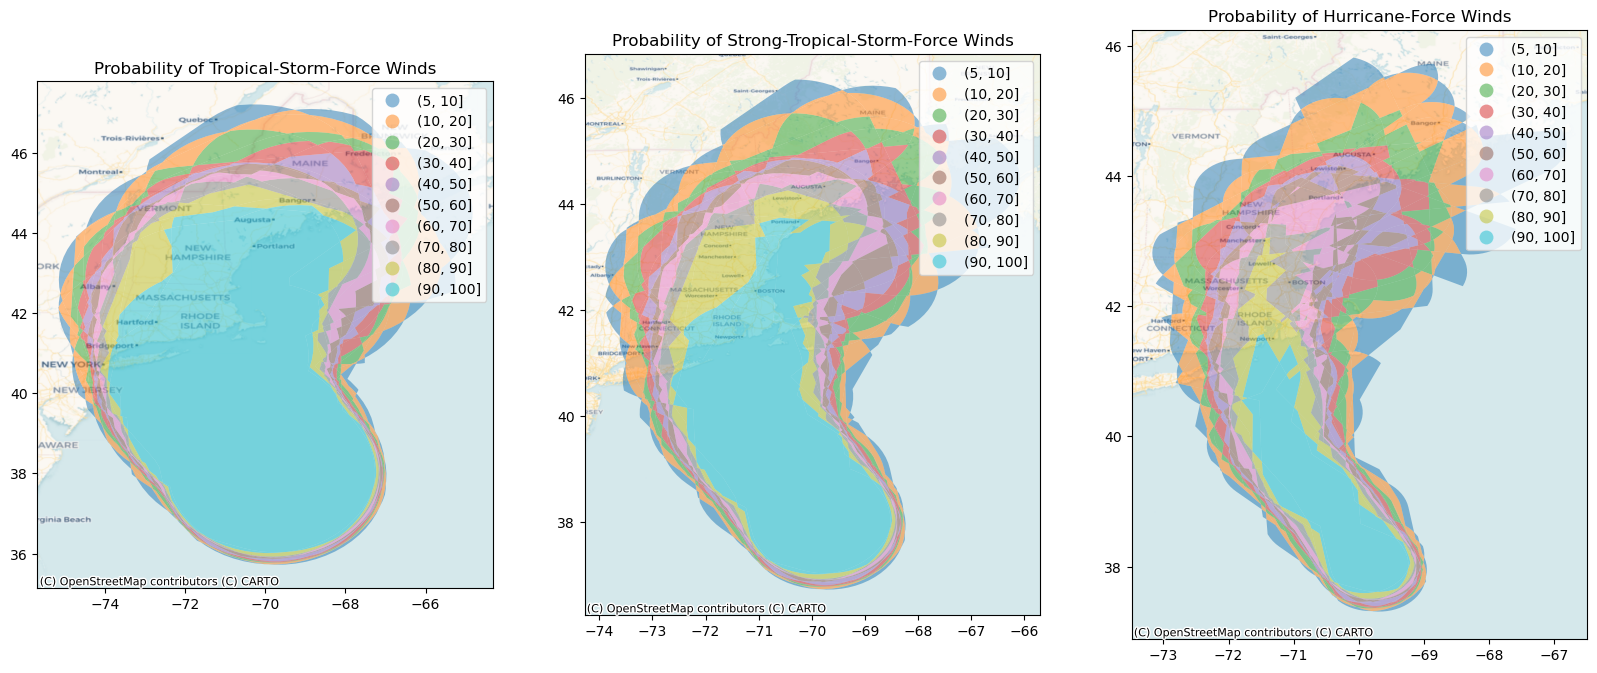

In [80]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
def count_overlapping_features(gdf):
    #generating all of the split pieces
    import shapely
    bounds = gdf.geometry.exterior.unary_union
    new_polys = list(shapely.ops.polygonize(bounds))
    new_gdf = gpd.GeoDataFrame(geometry=new_polys, crs=gdf.crs)
    new_gdf['id'] = range(len(new_gdf))

    #count overlapping by sjoin between pieces representative point (point inside polygon) and the input gdf 
    new_gdf_centroid = new_gdf.copy()
    new_gdf_centroid['geometry'] = new_gdf.geometry.representative_point()
    overlapcount = gpd.sjoin(new_gdf_centroid,gdf)
    overlapcount = overlapcount.groupby(['id'])['index_right'].count().rename('count').reset_index()
    out_gdf = pd.merge(new_gdf,overlapcount)
    return out_gdf
category1, category2, category3 = combined_gdf.copy(), combined_gdf.copy(), combined_gdf.copy()
bin_edges = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
axes = [ax1, ax2, ax3]
categories = [category1, category2, category3]
titles = ['Probability of Tropical-Storm-Force Winds', 'Probability of Strong-Tropical-Storm-Force Winds', 'Probability of Hurricane-Force Winds']
buffers = [300, 160, 80]
for i in range(3):   
    
    categories[i] = categories[i].to_crs(epsg=3857) 
    categories[i]['geometry'] = categories[i].geometry.buffer(buffers[i] * 1000) #Run Only ONCE
    categories[i] = categories[i].to_crs(epsg=4326)
    
    overlaps = count_overlapping_features(categories[i])
    overlaps['prob'] = overlaps['count']/20

    overlaps['bin'] = pd.cut(overlaps['prob'] * 100, bins=bin_edges)

    axes[i].set_title(titles[i])
    overlaps.plot(column = 'bin', ax=axes[i], alpha=0.5, legend=True)
    ctx.add_basemap(ax = axes[i], crs=overlaps.crs, source = ctx.providers.CartoDB.Voyager)

In [30]:
# track shows where the storm actually went in the past
link2 = 'https://files.bwsi-remote-sensing.net/data/final_2024/day1/day1_track_past.geojson'
day1_track = gpd.read_file(link2)
day1_track

,geometry
0,"LINESTRING (-69.4 37.7, -69.8 38)"


In [31]:
day1_grouped= day1_grouped.groupby('datetime')
day1_grouped

POINT (-69.78573342551611 37.99513208811304)
0      9.007970e+06
8      9.019124e+06
16     9.031998e+06
24     9.011318e+06
32     9.041558e+06
40     9.035998e+06
48     9.023242e+06
56     8.999162e+06
64     9.015424e+06
72     9.012479e+06
80     9.030632e+06
88     9.027519e+06
96     9.018825e+06
104    9.002350e+06
112    9.027246e+06
120    9.019948e+06
128    9.020449e+06
136    9.003668e+06
144    9.009149e+06
152    8.989746e+06
dtype: float64
POINT (-70.33777082303466 38.766710906585644)
1      9.149853e+06
9      9.144733e+06
17     9.119307e+06
25     9.124394e+06
33     9.134922e+06
41     9.157929e+06
49     9.086625e+06
57     9.102579e+06
65     9.103198e+06
73     9.127173e+06
81     9.131202e+06
89     9.131895e+06
97     9.102925e+06
105    9.095039e+06
113    9.116236e+06
121    9.161987e+06
129    9.178151e+06
137    9.161314e+06
145    9.091893e+06
153    9.103194e+06
dtype: float64
POINT (-71.14474280186091 39.72392699763031)
2      9.271333e+06
10     9.28647

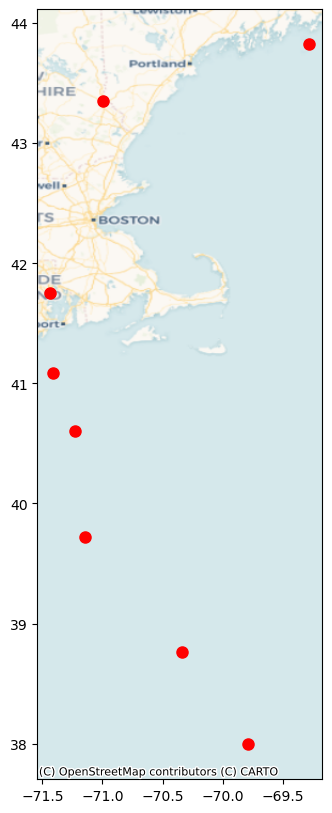

In [62]:
# each forecast report has a number of possible hurricane routes
# they are identified by the prediction column
fig, ax = plt.subplots(1, 1, figsize=(10,10))


for datetime, point in day1_grouped:
    point = point.to_crs(epsg=3857)
    centroid = point.dissolve().centroid.to_crs(epsg=4326)#.values[0]
    centroid = centroid.values[0]
    print(centroid)
    print(distances)
    ax.plot(centroid.x, centroid.y, 'ro', label=f'{pred_id}', markersize=8)
ctx.add_basemap(ax, crs=day1_forecast.crs, source = ctx.providers.CartoDB.Voyager)

# Location of Areas of Interest


In [ ]:
!wget https://files.bwsi-remote-sensing.net/data/final/R1-Hospitals.zip -O R1-Hospitals.zip
!unzip R1-Hospitals.zip

In [ ]:
!wget https://files.bwsi-remote-sensing.net/data/final/R1-Shelters.zip -O R1-Shelters.zip
!unzip R1-Shelters.zip

In [ ]:
hospitals_gdf = gpd.read_file('R1-Hospitals/')
shelters_gdf = gpd.read_file('R1-Shelters/')

In [ ]:
hospitals_gdf

In [ ]:
shelters_gdf

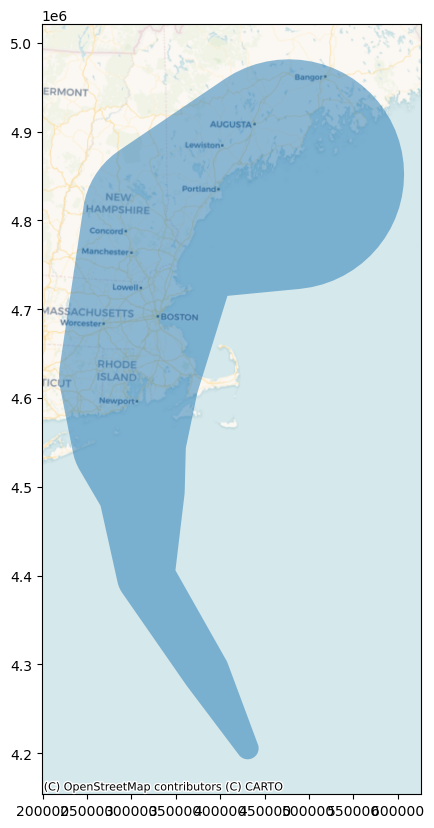

In [12]:
#put it in meters
day1_forecast_utm = (day1_forecast
                     .to_crs(day1_forecast.estimate_utm_crs())
                    )

day1_forecast_utm["x"] = day1_forecast_utm.geometry.x
day1_forecast_utm["y"] = day1_forecast_utm.geometry.y

day1_forecast_utm
#centroids
day1_forecast_centroid_utm = (day1_forecast_utm
     .groupby('forecastHour', as_index=False)
     [['x','y']]
     .mean()
     .assign(geometry = lambda df : gpd.points_from_xy(x=df.x,y=df.y, crs=day1_forecast_utm.crs ))
    )


day1_forecast_centroid_utm

dist_gdf = (day1_forecast_utm
 .merge(day1_forecast_centroid_utm[['forecastHour','geometry']], how='left', on='forecastHour', suffixes=['_orig', '_cent'])
 .assign(dist_m = lambda df: df.geometry_orig.distance(df.geometry_cent))
)

dist_gdf

#distances between points and centroids
dist_gdf = (day1_forecast_utm
 .merge(day1_forecast_centroid_utm[['forecastHour','geometry']], how='left', on='forecastHour', suffixes=['_orig', '_cent'])
 .assign(dist_m = lambda df: df.geometry_orig.distance(df.geometry_cent))
)

dist_gdf

radii = dist_gdf.groupby("forecastHour", as_index=False)[["dist_m"]].mean()
radii

#.pipe switches the grouped dataframe to a geodataframe
day1_forecast_dist_m_utm = (day1_forecast_centroid_utm.merge(radii, on="forecastHour")
                           .pipe(gpd.GeoDataFrame))
day1_forecast_dist_m_utm

#makes points into circles
day1_forecast_circle  = day1_forecast_dist_m_utm
day1_forecast_circle['geometry'] = day1_forecast_circle.geometry.buffer(day1_forecast_circle.dist_m)
day1_forecast_circle
def visualizeUncertainty(all_forecasts):
    forecasts_list = all_forecasts['geometry']

    merged = forecasts_list[0].union(forecasts_list[1]).convex_hull

    for i in range(1, len(forecasts_list)-1): #iterates over polygons
        next = forecasts_list[i].union(forecasts_list[i+1]).convex_hull
        merged = merged.union(next)


    return merged

# Convert to a GeoDataFrame
cone_of_uncertainty = gpd.GeoDataFrame(geometry=[visualizeUncertainty(day1_forecast_circle)], crs=day1_forecast_circle.crs)

fig, ax = plt.subplots(1, 1, figsize=(10,10))

cone_of_uncertainty.plot(ax=ax, alpha=0.5)

ctx.add_basemap(ax,
               crs=day1_forecast_circle.crs,
               source=ctx.providers.CartoDB.Voyager
              )

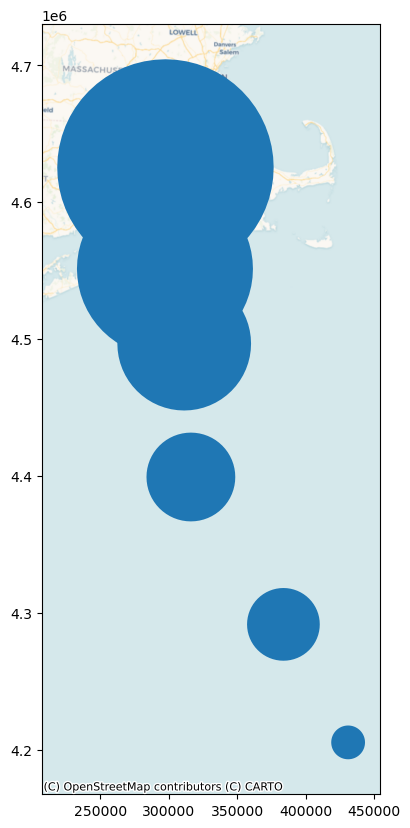

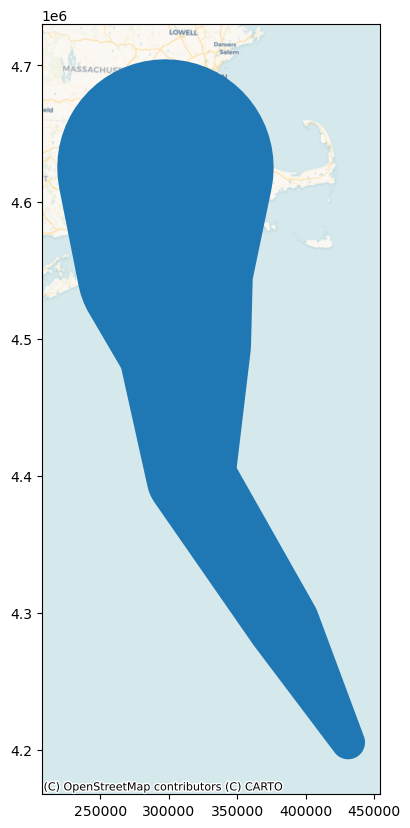

In [22]:
day1_forecast_circle_partial = day1_forecast_circle.iloc[:6,:]
fig, ax = plt.subplots(1, 1, figsize=(10,10))

day1_forecast_circle_partial.plot(ax=ax)

ctx.add_basemap(ax,
               crs=day1_forecast_circle.crs,
               source=ctx.providers.CartoDB.Voyager
              )

def visualizeUncertainty(all_forecasts):
    forecasts_list = all_forecasts.geometry

    merged = forecasts_list[0].union(forecasts_list[1]).convex_hull

    for i in range(1, len(forecasts_list)-1): #iterates over polygons
        next = forecasts_list[i].union(forecasts_list[i+1]).convex_hull
        merged = merged.union(next)


    return merged

cone = visualizeUncertainty(day1_forecast_circle_partial)
fig, ax = plt.subplots(1, 1, figsize=(20,10))

p = gpd.GeoSeries(cone)
p.plot(ax=ax)


ctx.add_basemap(ax,
               crs=day1_forecast_circle.crs,
               source=ctx.providers.CartoDB.Voyager
              )

plt.show()

In [23]:
import shapely.geometry
from pyproj import Transformer

# Assuming the UTM zone is 33N. Replace '33N' with the appropriate UTM zone for your data.
transformer = Transformer.from_crs("epsg:26919", "epsg:4326", always_xy=True)

# Reproject the UTM polygon to WGS84.
cone2 = shapely.ops.transform(transformer.transform, cone)

# Convert Shapely polygon to GeoJSON format.
geojson = shapely.geometry.mapping(cone2)

# Load the GeoJSON into GEE as a feature.
cone_GEE = ee.Feature(geojson)

# Remove misclassified pixels in areas with slopes greater than 5%
srtm = ee.Image('USGS/SRTMGL1_003')
terrain = ee.Algorithms.Terrain(srtm)
slope = terrain.select('slope')


# Load the GeoTIFF as an Earth Engine Image
#coastline = ee.FeatureCollection('projects/ee-amricheatef-example2/assets/costline/tl_2019_us_coastline')

# Define visualization parameters with min and max values
vis_params = {
    'min': -25,      
    'max': 700   
}

slope_vis = {
    'min': 0,          
    'max': 30,        
    'palette': "GnBu"  
}

# If you want to visualize the feature, you can use geemap.
Map = geemap.Map()
Map.addLayer(srtm, vis_params, 'srtm')
Map.addLayer(slope, slope_vis, 'slope')
Map.addLayer(cone_GEE, {}, 'Cone day 1')
#Map.addLayer(coastline, {}, 'coastline')
Map.centerObject(cone_GEE, 10)
Map

Map(center=[40.65396823011885, -71.15131317312112], controls=(WidgetControl(options=['position', 'transparent_…

In [24]:
# Load the GeoTIFF as an Earth Engine Image
image1 = ee.Image('projects/remote-sensing-project-428819/assets/n42_w071_1arc_v3')
image2 = ee.Image('projects/remote-sensing-project-428819/assets/n42_w072_1arc_v3')

# Define visualization parameters with min and max values
vis_params = {
    'min': -25,            # Minimum value for color scaling
    'max': 700,        # Maximum value for color scaling
    'palette': ['blue', 'green', 'yellow', 'red']  # Color palette (optional)
}

# If you want to visualize the feature, you can use geemap.
Map = geemap.Map()
Map.addLayer(image1, vis_params, 'tile-1')
Map.addLayer(image2, vis_params, 'tile-2')
Map.addLayer(cone_GEE, {}, 'Polygon')
Map.centerObject(cone_GEE, 10)
Map

Map(center=[40.65396823011885, -71.15131317312112], controls=(WidgetControl(options=['position', 'transparent_…

In [26]:
image1 = ee.Image('projects/remote-sensing-project-428819/assets/svi_2020_tract_overall_wgs84')

Map = geemap.Map()

Map.addLayer(image1,{}, 'SVI Data')

Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…